銀行が融資をした際に、融資した資金が回収できるかどうかを予測するモデルを作成する。
下記の処理で読み込んでいるCSVは、最終列（`'Loan_Status'`、融資した資金が実際に回収できた場合はY、そうでなければN）が目的変数、それ以外が説明変数（の候補）である。

このデータに対し、機械学習（深層学習含む）のモデルを実装することで、`'Loan_Status'` の予測を行う。



In [1]:
import pandas as pd
import numpy as np
from numpy import nan
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import ElasticNet

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE

## ファイルの読み込み

In [2]:
df = pd.read_csv('loan.csv')

In [3]:
print(f'データ数: {len(df)}')
print(f'カラム名: {str(df.columns)}')

データ数: 614
カラム名: Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')


（カラム名の規則が統一されていないので、修正する）

In [4]:
df = df.rename(columns={
    'Loan_ID':'loan_id',
    'Gender':'gender',
    'Married':'married',
    'Dependents':'dependents',
    'Education':'education',
    'Self_Employed':'self_employed',
    'ApplicantIncome':'applicant_income',
    'CoapplicantIncome':'coapplicant_income',
    'LoanAmount':'loan_amount',
    'Loan_Amount_Term':'loan_amount_term',
    'Credit_History':'credit_history',
    'Property_Area':'property_area',
    'Loan_Status':'loan_status',
})

In [5]:
df.head()

,loan_id,gender,married,dependents,education,self_employed,applicant_income,coapplicant_income,loan_amount,loan_amount_term,credit_history,property_area,loan_status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


## 各カラムの意味合いを推測

分析の際は、各カラムが何を意味しているのかを把握しておいた方が、妥当性の判断や結果の解釈などの場面で役に立つと考える。しかし、今回は各カラムの意味は与えられていないため、与えられた情報の中から推測をする。

**実務ではデータを受け取った段階で確認すべきだが、今回は確認先がない状況なので、カラム名・ユニーク数・dtypeなどから推測することにした。**

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   loan_id             614 non-null    object 
 1   gender              601 non-null    object 
 2   married             611 non-null    object 
 3   dependents          599 non-null    object 
 4   education           614 non-null    object 
 5   self_employed       582 non-null    object 
 6   applicant_income    614 non-null    int64  
 7   coapplicant_income  614 non-null    float64
 8   loan_amount         592 non-null    float64
 9   loan_amount_term    600 non-null    float64
 10  credit_history      564 non-null    float64
 11  property_area       614 non-null    object 
 12  loan_status         614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


object のデータはカテゴリ変数、int・float は数量変数であると思われるが、ユニーク数などを見てみないと断定はできないので、もう少し確認する。

In [7]:
df.nunique()

loan_id               614
gender                  2
married                 2
dependents              4
education               2
self_employed           2
applicant_income      505
coapplicant_income    287
loan_amount           203
loan_amount_term       10
credit_history          2
property_area           3
loan_status             2
dtype: int64

object のカラムに含まれるユニークな値を確認してみる

In [8]:
print(f"gender: {set(df['gender'])}")
print(f"married: {set(df['married'])}")
print(f"dependents: {set(df['dependents'])}")
print(f"education: {set(df['education'])}")
print(f"self_employed: {set(df['self_employed'])}")
print(f"property_area: {set(df['property_area'])}")
print(f"loan_status: {set(df['loan_status'])}")

gender: {nan, 'Female', 'Male'}
married: {'Yes', nan, 'No'}
dependents: {nan, '3+', '2', '1', '0'}
education: {'Not Graduate', 'Graduate'}
self_employed: {'Yes', nan, 'No'}
property_area: {'Rural', 'Semiurban', 'Urban'}
loan_status: {'N', 'Y'}


dependents　だけ、順序変数であると考えられる。その他は通常のカテゴリ変数で良さそう。

以下が、ここまでの観察結果を踏まえた各カラムの意味合い。

- loan_id： 申請者のＩＤ  
- gender： 性別  
- married： 既婚か否か
- dependents： 扶養家族の人数(?)
- education： 学歴
- self_employed： 自営業の有無
- applicant_income： 申請者の収入
- coapplicant_income： 共同申請者の収入
- loan_amount： 借入金額
- loan_amount_term： 借入期間(月?)
- credit_history： 支払い履歴(信用度?)
- property_area： 居住地域(家の購入先の地域?)
- loan_status： 実際に返済をしたか否か(目的変数)

## 探索的データ分析

### 数量変数の全体像を観察

#### 基本統計量

In [9]:
df.describe()

,applicant_income,coapplicant_income,loan_amount,loan_amount_term,credit_history
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


- 中央値や75%点のデータと max の差を確認すると、applicant_income, coapplicant_income, loan_amount は外れ値を含んでいる可能性がありそうなことがわかる

#### 箱ひげ図

<AxesSubplot:>

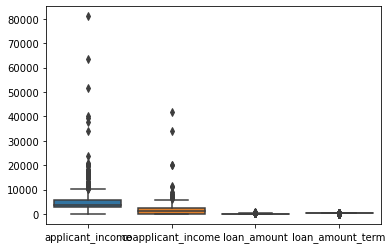

In [10]:
sns.boxplot(data=df.loc[:, ['applicant_income', 'coapplicant_income', 'loan_amount', 'loan_amount_term']])

- 箱ひげ図を見てみても、applicant_income, coapplicant_income は全体の傾向に比べて圧倒的に大きい値の人が一定数いそう
- 他の図は潰れてしまっているので、下で個別に見る

<AxesSubplot:>

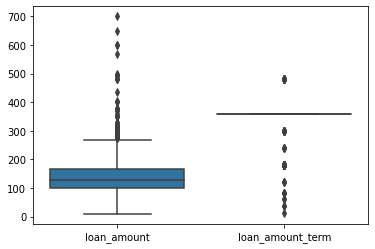

In [11]:
sns.boxplot(data=df.loc[:, ['loan_amount', 'loan_amount_term']])

- loan_amount も高いサンプルはかなり高いように見える
- （loan_amount_term は１０個しか値がないので、綺麗な箱ひげ図にはならなかった）

### 数量変数の相関関係を観察

数量データ：
- applicant_income
- coapplicant_income
- loan_amount
- loan_amount_term
- credit_history

#### 散布図

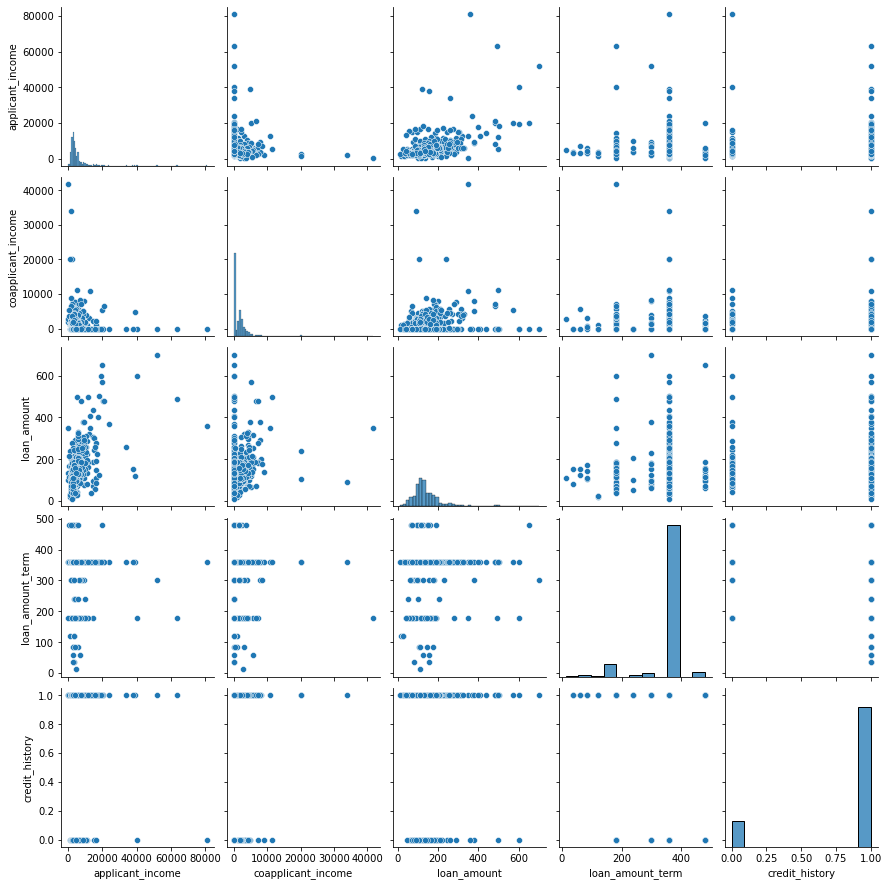

In [12]:
sns.pairplot(df.loc[:, ['applicant_income', 'coapplicant_income', 'loan_amount', 'loan_amount_term', 'credit_history']])

- loan_amount x applicant_income と、loan_amount x coapplicant_income あたりに相関がありそうに見える
- （applicant_income と coapplicant_income は、０側に大きく偏っているような形をしているので、対数をとっても良さそう）
- 次に実際に相関係数を確認してみる

#### ヒートマップ

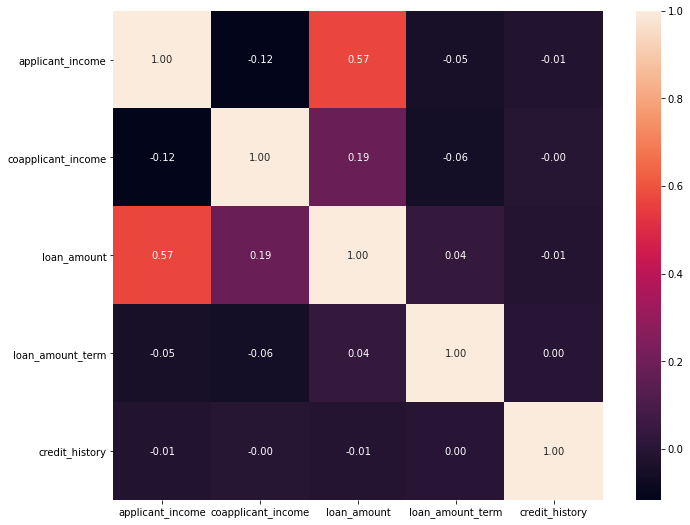

In [13]:
plt.figure(figsize=(12, 9))

# annot : 数値を表示するかどうか(annotation)
# square: 四角を正方形に合わせるかどうか
# fmt   : 表示する数値の形式(formatting)
sns.heatmap(df.corr(), annot=True, square=True, fmt='.2f')
plt.show()

- どの組み合わせもそこまで相関は高くなさそう
- 強いて言うなら、 loan_amount x applicant_income にある程度の正の相関はありそう -> 「収入が多い人に多くのお金を貸し出している」 -> 正しそう
- その他はあまり強い相関関係は見られなかった
- loan_amount x applicant_income だけ少し細かく見てみる

#### 散布図（個別）

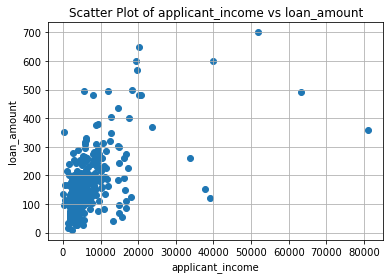

In [14]:
plt.scatter(x=df['applicant_income'], y=df['loan_amount'])  # 散布図をプロット

plt.title('Scatter Plot of applicant_income vs loan_amount')  # 図のタイトル
plt.xlabel('applicant_income')  # x軸のラベル
plt.ylabel('loan_amount')  # y軸のラベル
plt.grid(True)  # グリッド線を表示

plt.show()

# 傾向線を見たいならこちら
# sns.regplot(x=df.ApplicantIncome, y=df.LoanAmount)

- 散布図からも loan_amount と applicant_income に正の相関があることがわかる
- 外れ値としても良さそうな値も散見されるが、一旦このまま進む

### 目的変数の偏りを観察

In [15]:
# ユニークなデータの数をそれぞれ数えるための関数を作成
def show_uniq_data_count(dataframe, column):
    print(f'カラム名: {column}')
    uniqs = set(dataframe[column])
    data = list(dataframe[column])
    count_all = len(data)
    for uniq in uniqs:
        print(f'   - {uniq}: {data.count(uniq)} ... {round(data.count(uniq)/count_all, 3) * 100} %')

In [16]:
show_uniq_data_count(df, 'loan_status')

カラム名: loan_status
   - N: 192 ... 31.3 %
   - Y: 422 ... 68.7 %


- あまり偏りは大きくないので、オーバーサンプリングやアンダーサンプリングをするかは精度を見てみてから判断する

### 目的変数と説明変数の関係性を事前に確認

#### 数量変数

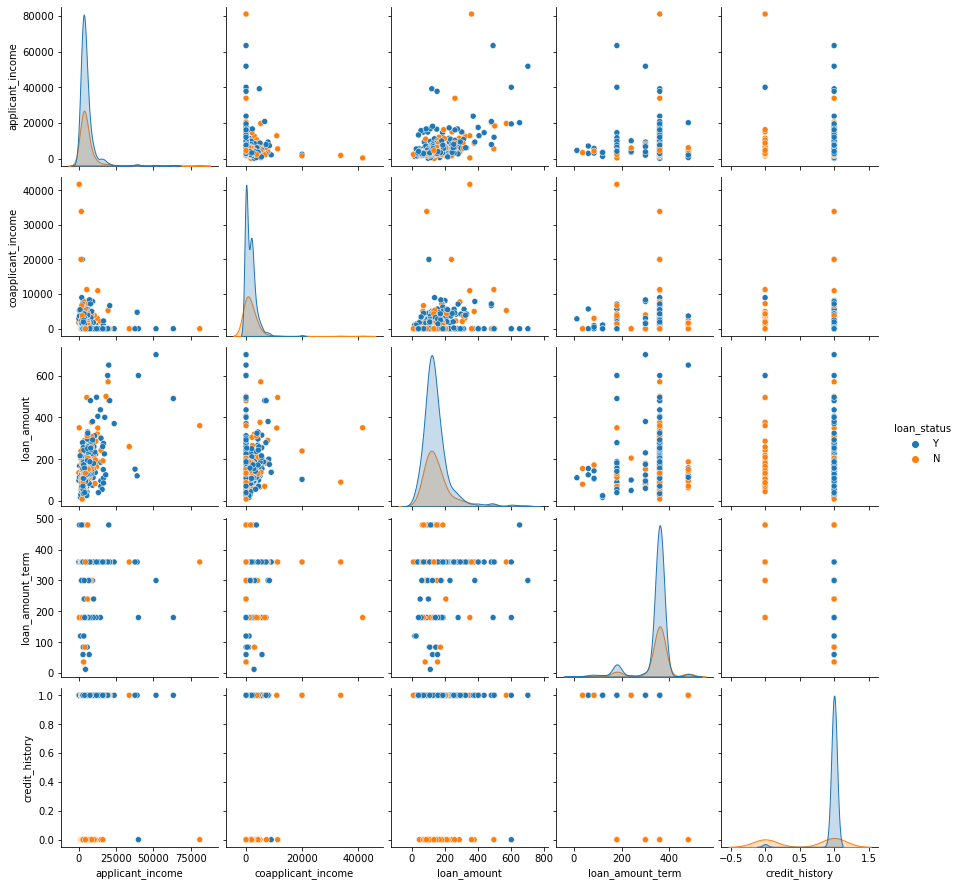

In [17]:
sns.pairplot(df, hue='loan_status')

正例（N：返済できなかった人）・負例（Y：返済できた人）を分類するために重要そうな変数を確認する
- 対角成分に存在するグラフで、その変数単体で分類がどの程度簡単にできそうかを確認することができる
    - credit_history が、正例と負例で最も分布の形が異なっていそう（分類の際に寄与する可能性が高い？）
    - それ以外の変数は概ね正例と負例で分布の形が大きく異なるような傾向は見られない（線形なモデルでは分類困難な可能性）
- 対角成分以外に存在するグラフで、２つの変数の組み合わせで分類がどの程度簡単にできそうかを確認することができる
    - credit_history を含まない２つの変数の組み合わせでは、どのグラフも正例と負例が複雑に混ざって配置されている（線形なモデルでは分類困難な可能性）
    - credit_history は、どの変数と組み合わせた場合でも、分離がある程度できているように見える（credit_history=0 のユーザが基本的に返済できていなそう）

#### カテゴリ変数

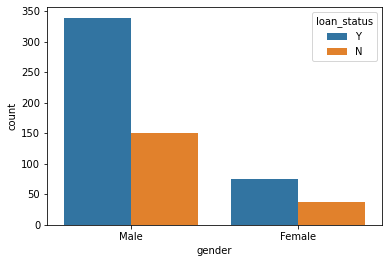

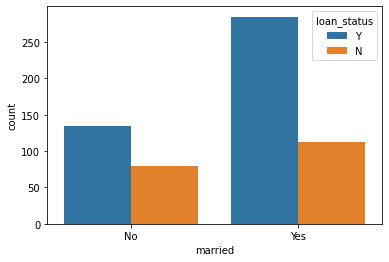

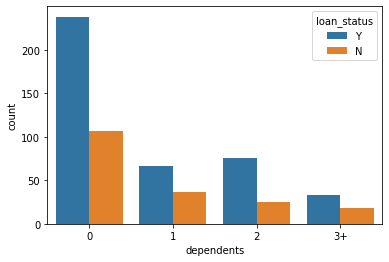

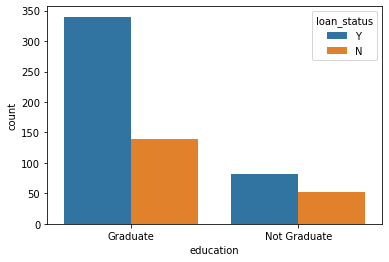

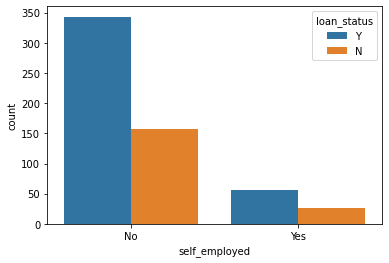

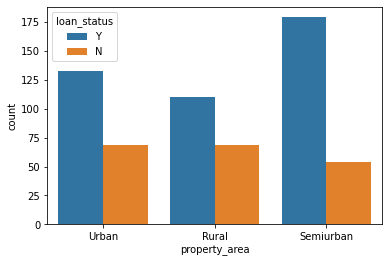

In [18]:
cols_category = ['gender', 'married', 'dependents', 'education', 'self_employed', 'property_area']
for col in cols_category:
    plt.figure() # これを宣言しないと、for文の一番最後のグラフしか表示できない
    sns.countplot(data=df, x=col, hue='loan_status')

正例（N：返済できなかった人）・負例（Y：返済できた人）を分類するために重要そうな変数を確認する
- 女性の方が男性よりもわずかに返済できない人（N）の割合が高そう
- 結婚していない人の方が返済できない人（N）の割合が高そう
- 扶養家族の人数が 3+ であると、返済できない人（N）の割合が高そう
- 卒業していない人の方が、返済できない人（N）の割合が高そう
- 田舎（Rural）が最も返済できない人（N）の割合が高そう

**各群の間で有意な差があるかを確認することが主題である場合は検定をしてみた方が良いが、今回はあくまで事前分析なので検定は割愛する**

### まとめ

ここまで見てきた中で，今後の分析に重要そうな内容を抜粋したものが以下．

- カテゴリ変数は、gender, married,  dependents,  education,  self_employed,  property_area,  (目的変数: loan_status)
    - dependents　だけ、順序変数であると考えられる。その他は通常のカテゴリ変数で良さそう。
- 数量変数は、applicant_income, coapplicant_income, loan_amount, loan_amount_term, credit_history
    - applicant_income と coapplicant_income は、０側に大きく偏っているような形をしているので、対数をとっても良さそう
    - loan_amount と applicant_income に正の相関がありそう。その他の数量変数の組み合わせでは相関はあまり大きくなかった
        - 多重共線性の問題は特に気にしなくても大丈夫そう
        - 欠損値は線形補完で処理するのが良さそう
    - applicant_income, coapplicant_income は全体の傾向に比べて圧倒的に大きい値の人が一定数いそう（外れ値を除外して分析しても良さそう）
- 欠損を含んでいたカラムは、 gender, married, dependents, self_employed, loan_amount, loan_amount_term, credit_history
    - 補完の方針
        - 行ごと削除： maried
        - 平均：loan_amount_term
        - 最頻値：dependents
        - 別のデータで補完：gender, self_employed
        - 線形：loan_amount
- 正例と負例の数の偏りはあまり大きくない
    - オーバーサンプリング(SMOTEなど)・アンダーサンプリング(randomなど)は一旦実施せずに進んで良さそう
- 採用するモデルについて
    - 数量変数: credit_history が強く分類に寄与してくれそうであるが、その他の変数を利用しても簡単には分類できなそう（目視レベルでは分類規則を発見できなそう）であるため、非線形なモデルを採用するのが良さそう?
    - カテゴリ変数: 各変数がそれなりに返済できたか否かに寄与していそうに見えた。
    - 結論：高い精度だけを求めるのであれば、勾配ブースティングやランダムフォレストなどを採用するべきであるが、カテゴリ変数やcredit_history などを利用すれば、線形モデルでもある程度分類可能そうであると判断したのと、今回の課題を踏まえて、考察を得たり、議論をすることが重要であると考えたため、解釈性にも優れた **ロジスティック回帰** を採用する

## 前処理

In [19]:
df_prep = df.copy()

### 対数をとる

(array([ 17., 224., 182.,  81.,  29.,  25.,  15.,   7.,   5.,   7.,   6.,
          3.,   5.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   1.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([  150.,  1767.,  3384.,  5001.,  6618.,  8235.,  9852., 11469.,
        13086., 14703., 16320., 17937., 19554., 21171., 22788., 24405.,
        26022., 27639., 29256., 30873., 32490., 34107., 35724., 37341.,
        38958., 40575., 42192., 43809., 45426., 47043., 48660., 50277.,
        51894., 53511., 55128., 56745., 58362., 59979., 61596., 63213.,
        64830., 66447., 68064., 69681., 71298., 72915., 74532., 76149.,
        77766., 79383., 81000.]),
 <BarContainer object of 50 artists>)

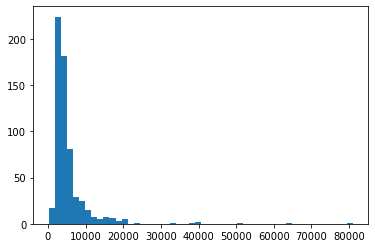

In [20]:
plt.hist(df_prep['applicant_income'], bins=50)

In [21]:
df_prep['applicant_income'] = np.log(np.array(df_prep['applicant_income']))
df_prep['coapplicant_income'] = np.log(np.array(df_prep['applicant_income']))

(array([ 1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  2.,  0.,
         0.,  0.,  3.,  0.,  3.,  4., 13., 22., 31., 56., 51., 71., 67.,
        50., 49., 34., 43., 17., 20., 16., 13.,  9.,  5.,  8.,  8.,  6.,
         2.,  1.,  0.,  0.,  2.,  2.,  0.,  1.,  0.,  1.,  1.]),
 array([ 5.01063529,  5.13646668,  5.26229806,  5.38812944,  5.51396083,
         5.63979221,  5.76562359,  5.89145497,  6.01728636,  6.14311774,
         6.26894912,  6.3947805 ,  6.52061189,  6.64644327,  6.77227465,
         6.89810604,  7.02393742,  7.1497688 ,  7.27560018,  7.40143157,
         7.52726295,  7.65309433,  7.77892572,  7.9047571 ,  8.03058848,
         8.15641986,  8.28225125,  8.40808263,  8.53391401,  8.6597454 ,
         8.78557678,  8.91140816,  9.03723954,  9.16307093,  9.28890231,
         9.41473369,  9.54056507,  9.66639646,  9.79222784,  9.91805922,
        10.04389061, 10.16972199, 10.29555337, 10.42138475, 10.54721614,
        10.67304752, 10.7988789 , 10.92471029, 11.05054167,

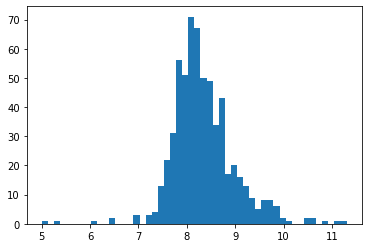

In [22]:
plt.hist(df_prep['applicant_income'], bins=50)

### 欠損処理

補完の方針
- 行ごと削除： maried
- 平均：loan_amount_term
- 最頻値：dependents
- 別のデータで補完：gender, self_employed
- 線形：loan_amount

In [23]:
df_prep.isnull().sum()

loan_id                0
gender                13
married                3
dependents            15
education              0
self_employed         32
applicant_income       0
coapplicant_income     0
loan_amount           22
loan_amount_term      14
credit_history        50
property_area          0
loan_status            0
dtype: int64

In [24]:
df_prep['gender'] = df_prep['gender'].fillna('other')
df_prep = df_prep.dropna(subset=['married'])
df_prep['self_employed'] = df_prep['self_employed'].fillna('other')
df_prep['loan_amount_term'] = df_prep['loan_amount_term'].fillna(df_prep['loan_amount_term'].mean())
df_prep['credit_history'] = df_prep['credit_history'].fillna(-1)

df_prep['dependents'] = df_prep['dependents'].replace('3+', '3')
df_prep['dependents'] = df_prep['dependents'].fillna(df['dependents'].mode()[0])

df_prep['loan_amount'] = df_prep['loan_amount'].interpolate(method='linear')
df_prep = df_prep.dropna(subset=['loan_amount'])  # なぜか１件だけ null が残るので削除する

In [25]:
print(f'len: {len(df_prep)}')
df_prep.isnull().sum()

len: 610


loan_id               0
gender                0
married               0
dependents            0
education             0
self_employed         0
applicant_income      0
coapplicant_income    0
loan_amount           0
loan_amount_term      0
credit_history        0
property_area         0
loan_status           0
dtype: int64

### カテゴリ変数のマッピング

In [26]:
# gender_mapping = {'other': -1, "Male":0, "Female":1}
# df_prep["gender"] = df_prep["gender"].map(gender_mapping)
gender_dummies = pd.get_dummies(df_prep['gender'], prefix='gender', prefix_sep='_' )
df_prep = pd.concat([df_prep, gender_dummies], axis=1)
# 特徴量は少ない方が良いので、otherは消しておく(male: 0, female: 0 のときは必ず other なので　other は必要ない)
df_prep = df_prep.drop(columns=['gender', 'gender_other'])

married_mapping = {"No":0, "Yes":1}
df_prep["married"] = df_prep["married"].map(married_mapping)

education_mapping = {"Not Graduate":0, "Graduate":1}
df_prep["education"] = df_prep["education"].map(education_mapping)

# self_employed_mapping = {"other":-1, "No":0, "Yes":1}
# df_prep["self_employed"] = df_prep["self_employed"].map(self_employed_mapping)
self_employed_dummies = pd.get_dummies(df_prep['self_employed'], prefix='self_employed', prefix_sep='_')
df_prep = pd.concat([df_prep, self_employed_dummies], axis=1)
df_prep = df_prep.drop(columns=['self_employed', 'self_employed_other'])

property_area_dummies = pd.get_dummies(df_prep['property_area'], prefix='property_area', prefix_sep='_')
df_prep = pd.concat([df_prep, property_area_dummies], axis=1)
df_prep = df_prep.drop(columns=['property_area', 'property_area_Semiurban'])

loan_status_mapping = {"N":0, "Y":1}
df_prep["loan_status"] = df_prep["loan_status"].map(loan_status_mapping)

In [27]:
df_prep = df_prep.rename(columns={
    'gender_Female':'gender_female', 'gender_Male':'gender_male', 'self_employed_No':'self_employed_no',
    'self_employed_Yes':'self_employed_yes', 'property_area_Rural':'property_area_rural', 
    'property_area_Urban':'property_area_urban'})
df_prep.head()

,loan_id,married,dependents,education,applicant_income,coapplicant_income,loan_amount,loan_amount_term,credit_history,loan_status,gender_female,gender_male,self_employed_no,self_employed_yes,property_area_rural,property_area_urban
1,LP001003,1,1,1,8.430109,2.131810,128.0,360.0,1.0,0,0,1,1,0,1,0
2,LP001005,1,0,1,8.006368,2.080237,66.0,360.0,1.0,1,0,1,0,1,0,1
3,LP001006,1,0,0,7.856707,2.061368,120.0,360.0,1.0,1,0,1,1,0,0,1
4,LP001008,0,0,1,8.699515,2.163267,141.0,360.0,1.0,1,0,1,1,0,0,1
5,LP001011,1,2,1,8.597297,2.151448,267.0,360.0,1.0,1,0,1,0,1,0,1


### 学習データとテストデータの分割

In [28]:
# loan_id, loan_status を除外
X_columns = df_prep.drop(columns=['loan_id', 'loan_status']).columns
X = df_prep.drop(columns=['loan_id', 'loan_status']).values
y = df_prep.loc[:, ['loan_status']].values

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### 標準化

In [30]:
scaler = StandardScaler()
scaler.fit(X_train)  # 学習データで標準化の基準を用意（テストデータを含めないように注意）

X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

## 分類

### ロジスティック回帰（全特徴量）

In [31]:
lr = LogisticRegression()
lr.fit(X_train_std, y_train)

/Users/naoiharumi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LogisticRegression()

In [32]:
print(f'X_columns = {X_columns}')
print(f'coefficient = {lr.coef_}')
print(f'intercept = {lr.intercept_}')

y_pred = lr.predict(X_test_std)
print(y_pred)

X_columns = Index(['married', 'dependents', 'education', 'applicant_income',
       'coapplicant_income', 'loan_amount', 'loan_amount_term',
       'credit_history', 'gender_female', 'gender_male', 'self_employed_no',
       'self_employed_yes', 'property_area_rural', 'property_area_urban'],
      dtype='object')
coefficient = [[ 0.47331807 -0.17885419  0.09658919 -0.00735292  0.14670096 -0.11760523
   0.05805622  0.73599946  0.10047997  0.17524958 -0.25038957 -0.19615593
  -0.31845492 -0.23466379]]
intercept = [0.80874588]
[1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1
 1 1 1 1 0 1 1 0 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1
 1 1 1 1 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0
 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1]


In [33]:
print(f'confusion matrix = {confusion_matrix(y_true=y_test, y_pred=y_pred)}')
print(f'accuracy = {accuracy_score(y_true=y_test, y_pred=y_pred)}')
print(f'precision = {precision_score(y_true=y_test, y_pred=y_pred)}')
print(f'recall = {recall_score(y_true=y_test, y_pred=y_pred)}')
print(f'f1 score = {f1_score(y_true=y_test, y_pred=y_pred)}')

confusion matrix = [[ 11  40]
 [ 18 114]]
accuracy = 0.6830601092896175
precision = 0.7402597402597403
recall = 0.8636363636363636
f1 score = 0.7972027972027972


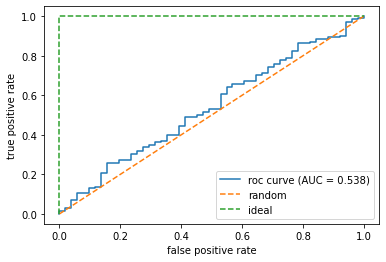

In [34]:
y_score = lr.predict_proba(X_test)[:, 1]  # 検証データがクラス1に属する確率
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_score)

plt.plot(fpr, tpr, label='roc curve (AUC = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], linestyle='--', label='random')
plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', label='ideal')
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

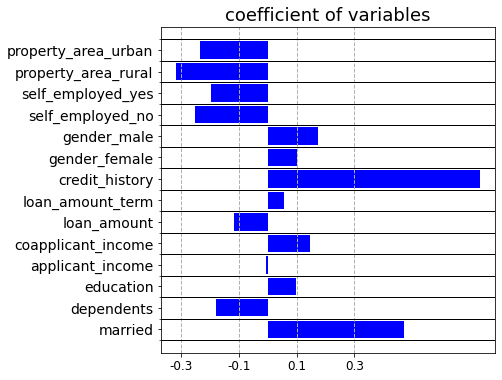

In [35]:
df_coef = pd.DataFrame({'coef':lr.coef_.flatten()}, index=X_columns)
x_pos = np.arange(len(df_coef))

fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(1, 1, 1)
ax1.barh(x_pos, df_coef['coef'], color='b')
ax1.set_title('coefficient of variables',fontsize=18)
ax1.set_yticks(x_pos)
ax1.set_yticks(np.arange(-1,len(df_coef.index))+0.5, minor=True)
ax1.set_yticklabels(df_coef.index, fontsize=14)
ax1.set_xticks(np.arange(-3,4,2)/10)
ax1.set_xticklabels(np.arange(-3,4,2)/10,fontsize=12)
ax1.grid(which='minor',axis='y',color='black',linestyle='-', linewidth=1)
ax1.grid(which='major',axis='x',linestyle='--', linewidth=1)
plt.show()

- accuracy とprecision はそこまで高くないが、recall は比較的高いことが分かる。
- とくにcredit_history, married の影響が大きく、一方でgender_female, applicant_income, loan_amount_term の影響が小さいことがわかる。
- 過去に credit_history がある人の方が今後も資金返済をする可能性が高いという結果は妥当である。既婚者や教育過程を卒業している人の方が、返済する意志が強いことがこの結果からわかる。
- また、loan_amount が大きいほど返済しづらくなることや、扶養家族が多いほど返済にお金をなかなか回せないことがわかる。
- applicant_income の影響力がそこまで大きくないのは、applicant_income が大きいほど、より多くのお金を借りるために返済できないリスクもあがるからだろうか。

### ロジスティック回帰（特徴量選択）

ロジスティック回帰を用いて、より高い精度を出すことができないかを模索してみる。
まずは、特徴量の数を少なくしてみて、精度の変化を観察する。

ロジスティック回帰に正則化項を加える方法と、ランダムフォレストなどで重要と判定された特徴量のみに絞って学習をしてみるなどの方法が考えられるが、今回はどちらもやってみる。

#### ランダムフォレストによる特徴量選択

In [36]:
rf = RandomForestClassifier(random_state=0, n_estimators=10)
rf.fit(X_train, y_train)

<ipython-input-36-5addeda98c25>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=10, random_state=0)

特徴量の重要度を調べる

In [37]:
feature = rf.feature_importances_
feature

array([0.02646134, 0.05483035, 0.0245987 , 0.14196647, 0.1715406 ,
       0.16424067, 0.06567599, 0.24656534, 0.01949905, 0.01258173,
       0.01683307, 0.01000873, 0.02855023, 0.01664772])

1   credit_history   0.24656534478451655
2   coapplicant_income   0.17154060118397246
3   loan_amount   0.1642406681335627
4   applicant_income   0.1419664747501242
5   loan_amount_term   0.06567599036028063
6   dependents   0.05483034788700995
7   property_area_rural   0.028550227673644256
8   married   0.026461343441986314
9   education   0.024598699104064484
10   gender_female   0.01949905153575166
11   self_employed_no   0.01683307065406637
12   property_area_urban   0.016647718171599327
13   gender_male   0.01258173231725053
14   self_employed_yes   0.010008730002170589


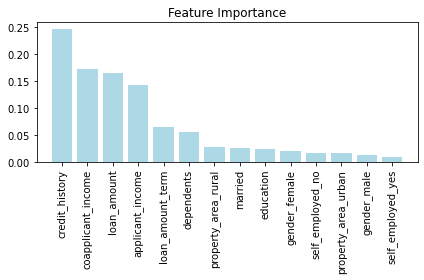

In [38]:
#特徴量の重要度を上から順に出力する
f = pd.DataFrame({
    'number': range(0, len(feature)),
    'feature': feature[:]})
f = f.sort_values('feature', ascending=False)

#特徴量の名前
label = X_columns[0:]

#特徴量の重要度順（降順）
indices = np.argsort(feature)[::-1]
for i in range(len(feature)):
    print(str(i + 1) + "   " + str(label[indices[i]]) + "   " + str(feature[indices[i]]))

plt.title('Feature Importance')
plt.bar(range(len(feature)),feature[indices], color='lightblue', align='center')
plt.xticks(range(len(feature)), label[indices], rotation=90)
plt.xlim([-1, len(feature)])
plt.tight_layout()
plt.show()

今回は、図より上から６番目までの特徴量 credit_history , coapplicant_income , loan_amount, applicant_income , loan_amount_term , dependents に絞ってロジスティック回帰を行ってみる。

In [39]:
X2_columns = df_prep.loc[:,['credit_history' , 'coapplicant_income' , 'loan_amount', 'applicant_income' , 'loan_amount_term' , 'dependents']].columns
X2=df_prep.loc[:,['credit_history' , 'coapplicant_income' , 'loan_amount', 'applicant_income' , 'loan_amount_term' , 'dependents']].values
y2=df_prep.loc[:,['loan_status']].values

In [40]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=0)

In [41]:
scaler = StandardScaler()
scaler.fit(X2_train) 
X2_train_std = scaler.transform(X2_train)
X2_test_std = scaler.transform(X2_test)

In [42]:
lr2 = LogisticRegression()
lr2.fit(X2_train_std, y2_train)

/Users/naoiharumi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LogisticRegression()

In [43]:
print(f'X2_columns = {X2_columns}')
print(f'coefficient = {lr2.coef_}')
print(f'intercept = {lr2.intercept_}')

y2_pred = lr2.predict(X2_test_std)
print(y2_pred) 

X2_columns = Index(['credit_history', 'coapplicant_income', 'loan_amount',
       'applicant_income', 'loan_amount_term', 'dependents'],
      dtype='object')
coefficient = [[ 0.69967156  0.17225044 -0.04070758 -0.09681076  0.02385818  0.00178377]]
intercept = [0.74749597]
[1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 1 0 1 1
 1 1 1 1 0 1 1 0 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 1
 1 1 1 1 1 0 0 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1]


In [44]:
print(f'confusion matrix = {confusion_matrix(y_true=y2_test, y_pred=y2_pred)}')
print(f'accuracy = {accuracy_score(y_true=y2_test, y_pred=y2_pred)}')
print(f'precision = {precision_score(y_true=y2_test, y_pred=y2_pred)}')
print(f'recall = {recall_score(y_true=y2_test, y_pred=y2_pred)}')
print(f'f1 score = {f1_score(y_true=y2_test, y_pred=y2_pred)}')

confusion matrix = [[ 16  35]
 [ 17 115]]
accuracy = 0.7158469945355191
precision = 0.7666666666666667
recall = 0.8712121212121212
f1 score = 0.8156028368794326


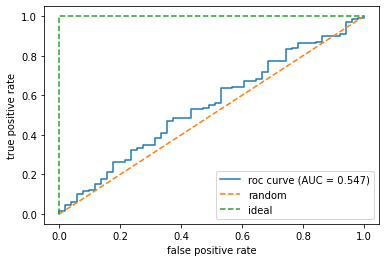

In [45]:
y_score = lr2.predict_proba(X2_test)[:, 1]  # 検証データがクラス1に属する確率
fpr, tpr, thresholds = roc_curve(y_true=y2_test, y_score=y_score)

plt.plot(fpr, tpr, label='roc curve (AUC = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], linestyle='--', label='random')
plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', label='ideal')
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

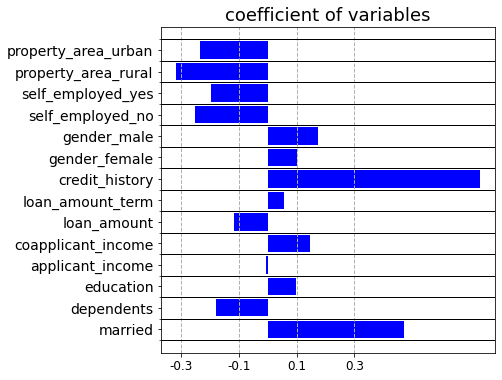

In [46]:
df_coef = pd.DataFrame({'coef':lr.coef_.flatten()}, index=X_columns)
x_pos = np.arange(len(df_coef))

fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(1, 1, 1)
ax1.barh(x_pos, df_coef['coef'], color='b')
ax1.set_title('coefficient of variables',fontsize=18)
ax1.set_yticks(x_pos)
ax1.set_yticks(np.arange(-1,len(df_coef.index))+0.5, minor=True)
ax1.set_yticklabels(df_coef.index, fontsize=14)
ax1.set_xticks(np.arange(-3,4,2)/10)
ax1.set_xticklabels(np.arange(-3,4,2)/10,fontsize=12)
ax1.grid(which='minor',axis='y',color='black',linestyle='-', linewidth=1)
ax1.grid(which='major',axis='x',linestyle='--', linewidth=1)
plt.show()

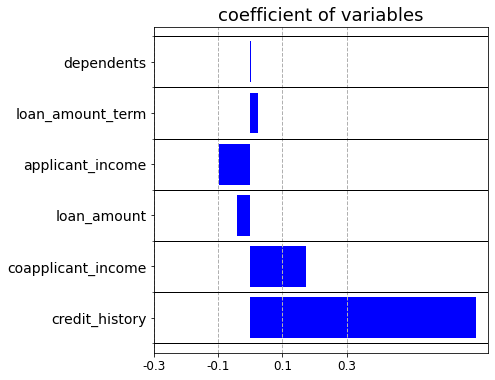

In [47]:
df2_coef = pd.DataFrame({'coef':lr2.coef_.flatten()}, index=X2_columns)
x2_pos = np.arange(len(df2_coef))

fig = plt.figure(figsize=(6,6))
ax2= fig.add_subplot(1, 1, 1)
ax2.barh(x2_pos, df2_coef['coef'], color='b')
ax2.set_title('coefficient of variables',fontsize=18)
ax2.set_yticks(x2_pos)
ax2.set_yticks(np.arange(-1,len(df2_coef.index))+0.5, minor=True)
ax2.set_yticklabels(df2_coef.index, fontsize=14)
ax2.set_xticks(np.arange(-3,4,2)/10)
ax2.set_xticklabels(np.arange(-3,4,2)/10,fontsize=12)
ax2.grid(which='minor',axis='y',color='black',linestyle='-', linewidth=1)
ax2.grid(which='major',axis='x',linestyle='--', linewidth=1)
plt.show()

-  ランダムフォレストによる特徴量選択により、全特徴量の場合と比べ、accuracy, precision, fi_score, AUC の値がすべて大きくなっていることが分かる。 -> 無事重要な情報を抽出して、より良いロジスティック回帰モデルを学習できていることがわかる
-  選んだ特徴量の中でも、特にcredit_history の影響が大きく、dependents, loan_amount_term, loan_amount の寄与は小さいことがわかる。
- ランダムフォレストによる特徴量選択の際、married の重要度が小さいことは意外な結果となった。

#### 正則化項による特徴量選択

- 今回は、L1ノルム罰則を課すLASSOを用いて正則化を行う

In [48]:
lr3 = LogisticRegression(penalty="l1", solver="liblinear")
lr3.fit(X_train_std, y_train)

/Users/naoiharumi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LogisticRegression(penalty='l1', solver='liblinear')

In [49]:
print(f'X_columns = {X_columns}')
print(f'coefficient = {lr3.coef_}')
print(f'intercept = {lr3.intercept_}')

y3_pred = lr3.predict(X_test_std)
print(y3_pred)

X_columns = Index(['married', 'dependents', 'education', 'applicant_income',
       'coapplicant_income', 'loan_amount', 'loan_amount_term',
       'credit_history', 'gender_female', 'gender_male', 'self_employed_no',
       'self_employed_yes', 'property_area_rural', 'property_area_urban'],
      dtype='object')
coefficient = [[ 0.4447152  -0.16186682  0.08784939  0.          0.10770106 -0.09536015
   0.04672413  0.72608593  0.          0.07363375 -0.19261828 -0.13687985
  -0.30072438 -0.21638585]]
intercept = [0.78758465]
[1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1
 1 1 1 1 0 1 1 0 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1
 1 1 1 1 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0
 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1]


In [50]:
print(f'confusion matrix = {confusion_matrix(y_true=y_test, y_pred=y3_pred)}')
print(f'accuracy = {accuracy_score(y_true=y_test, y_pred=y3_pred)}')
print(f'precision = {precision_score(y_true=y_test, y_pred=y3_pred)}')
print(f'recall = {recall_score(y_true=y_test, y_pred=y3_pred)}')
print(f'f1 score = {f1_score(y_true=y_test, y_pred=y3_pred)}')

confusion matrix = [[ 10  41]
 [ 18 114]]
accuracy = 0.6775956284153005
precision = 0.7354838709677419
recall = 0.8636363636363636
f1 score = 0.7944250871080138


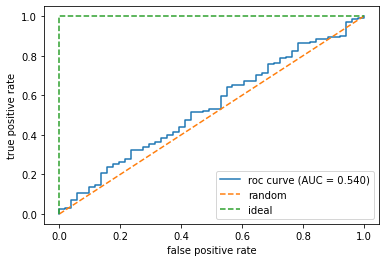

In [51]:
y_score = lr3.predict_proba(X_test)[:, 1]  # 検証データがクラス1に属する確率
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_score)

plt.plot(fpr, tpr, label='roc curve (AUC = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], linestyle='--', label='random')
plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', label='ideal')
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

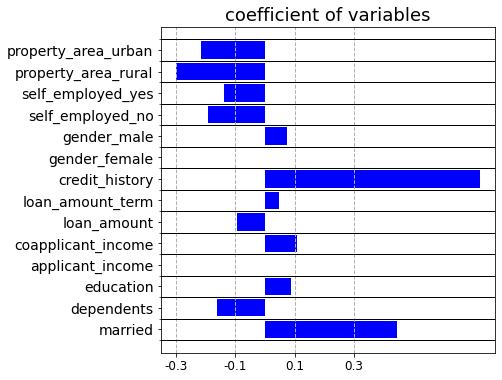

In [52]:
df_coef = pd.DataFrame({'coef':lr3.coef_.flatten()}, index=X_columns)
x_pos = np.arange(len(df_coef))

fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(1, 1, 1)
ax1.barh(x_pos, df_coef['coef'], color='b')
ax1.set_title('coefficient of variables',fontsize=18)
ax1.set_yticks(x_pos)
ax1.set_yticks(np.arange(-1,len(df_coef.index))+0.5, minor=True)
ax1.set_yticklabels(df_coef.index, fontsize=14)
ax1.set_xticks(np.arange(-3,4,2)/10)
ax1.set_xticklabels(np.arange(-3,4,2)/10,fontsize=12)
ax1.grid(which='minor',axis='y',color='black',linestyle='-', linewidth=1)
ax1.grid(which='major',axis='x',linestyle='--', linewidth=1)
plt.show()

- 正則化項による特徴量選択を行った結果、全特徴量を用いるよりaccuracy, precision, fi_score の値が低くなった。recallは同じ値であり、AUCはわずかに高くなったが、ランダムフォレストを用いた特徴量選択の際のAUCよりは低かった。
- 全特徴量でロジスティック回帰を行ったときと比べ、 credit_history, married の影響力の大きさはほとんど変わらず、影響力の小さかったgender_female, applicant_income の影響力はゼロになっており、重要でない特徴量の係数が小さくなるように正則化が行われていることがわかる。-> 正則化は確かに行われているが、それが精度にはつながらなかった。


### ロジスティック回帰（オーバーサンプリングあり）

In [53]:
sm = SMOTE()

X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

In [54]:
u, counts = np.unique(y_resampled, return_counts=True)
print(u)
print(counts)

[0 1]
[286 286]


それぞれのラベルが同じ数になっている（きちんとオーバーサンプリングできていそう）

In [55]:
lr4 = LogisticRegression()
lr4.fit(X_resampled, y_resampled)
y_re_pred = lr4.predict(X_test)

print('confusion matrix = \n', confusion_matrix(y_true=y_test, y_pred=y_re_pred))
print('accuracy = ', accuracy_score(y_true=y_test, y_pred=y_re_pred))
print('precision = ', precision_score(y_true=y_test, y_pred=y_re_pred))
print('recall = ', recall_score(y_true=y_test, y_pred=y_re_pred))
print('f1 score = ', f1_score(y_true=y_test, y_pred=y_re_pred))

confusion matrix = 
 [[27 24]
 [37 95]]
accuracy =  0.6666666666666666
precision =  0.7983193277310925
recall =  0.7196969696969697
f1 score =  0.7569721115537849


/Users/naoiharumi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


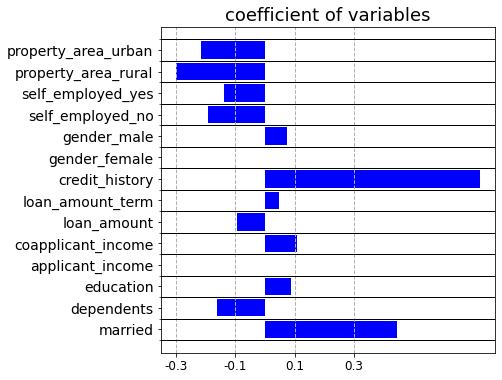

In [56]:
df4_coef = pd.DataFrame({'coef':lr4.coef_.flatten()}, index=X_columns)
x4_pos = np.arange(len(df_coef))

fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(1, 1, 1)
ax1.barh(x4_pos, df_coef['coef'], color='b')
ax1.set_title('coefficient of variables',fontsize=18)
ax1.set_yticks(x4_pos)
ax1.set_yticks(np.arange(-1,len(df_coef.index))+0.5, minor=True)
ax1.set_yticklabels(df4_coef.index, fontsize=14)
ax1.set_xticks(np.arange(-3,4,2)/10)
ax1.set_xticklabels(np.arange(-3,4,2)/10,fontsize=12)
ax1.grid(which='minor',axis='y',color='black',linestyle='-', linewidth=1)
ax1.grid(which='major',axis='x',linestyle='--', linewidth=1)
plt.show()

- 全特徴量でロジスティック回帰をしたときに比べ、precisionは79.8%と比較的高い値であったが、accuracy,recall,f1 scoreは低い値となった。負例のデータ数が大きい方が偽陽性も大きくなり、 precision は低下するのではないかと思ったので、予想とは異なる結果となった。
- オーバーサンプリングをする前は、正例データばかりを学習してしまったため、accuracy や recall が低下してた結果は妥当といえる。

### ランダムフォレスト

最後に、グリッドサーチを用いてランダムフォレスト単体で行ってみる。

In [57]:
#グリッドサーチを用いて最適なパラメータを利用
param_grid = {
    'n_estimators': [i for i in range(400, 450, 10)],
    'max_depth':  [i for i in range(3,4)]}

In [58]:
forest = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
y_train = y_train.reshape(-1, 1)
forest.fit(X_train, y_train)

/Users/naoiharumi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/naoiharumi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/naoiharumi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/naoiharumi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selec

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3],
                         'n_estimators': [400, 410, 420, 430, 440]})

In [59]:
y_pred=forest.predict(X_test)

In [60]:
print(f'confusion matrix = {confusion_matrix(y_true=y2_test, y_pred=y_pred)}')
print(f'accuracy = {accuracy_score(y_true=y2_test, y_pred=y_pred)}')
print(f'precision = {precision_score(y_true=y2_test, y_pred=y_pred)}')
print(f'recall = {recall_score(y_true=y2_test, y_pred=y_pred)}')
print(f'f1 score = {f1_score(y_true=y2_test, y_pred=y_pred)}')

confusion matrix = [[ 18  33]
 [  9 123]]
accuracy = 0.7704918032786885
precision = 0.7884615384615384
recall = 0.9318181818181818
f1 score = 0.8541666666666667


- ランダムフォレスト単体で行った結果、accuracy, precision, recall, fi scoreすべての値が最も高値をとることがわかった。
- したがって、今回はランダムフォレストが最も精度が高いことが分かる。
- また一般的に言われているように、ランダムフォレストは解釈性は低いが、精度が高いことが改めてわかった。